In [1]:
from pyspark.sql import SparkSession
import numpy as np
spark = SparkSession.builder.master('local[10]').appName('review').getOrCreate()

lc = spark.read.json('/project/cmsc25025/light_curve/lightcurves-sample.json')

+--------------------+-----+--------------------+--------------------+
|                flux|label|                name|                time|
+--------------------+-----+--------------------+--------------------+
|[194602.078125, 1...| conf|kplr002581316-201...|[1274.14019845467...|
|[6818722.5, 68190...| conf|kplr003632418-201...|[1274.14035648731...|
|[48374.2421875, 4...| conf|kplr003733628-201...|[1274.14035006258...|
|[86651.015625, 86...| conf|kplr004150804-201...|[1274.14022049512...|
|[12159.1142578125...|   eb|kplr001026032-201...|[1274.14036272274...|
|[96343.7734375, 9...|   eb|kplr001026957-201...|[1274.14035174874...|
|[208676.5625, 208...|   eb|kplr001161345-201...|[1274.14035372128...|
|[3648.109375, 364...|   eb|kplr001432214-201...|[1274.14031962276...|
|[7149.537109375, ...|   fp|kplr000892772-201...|[1274.14036161633...|
|[1170351.625, 117...|   fp|kplr001025986-201...|[1274.14035989129...|
|[36673.83984375, ...|   fp|kplr001027438-201...|[1274.14034383971...|
|[2524

In [42]:
gap = 0.0204
N = 4757
sz = (N-1)/2
u = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)



In [43]:
import math 
flux = lc.select('flux').rdd.collect()


def remove_nan(x):
    i = 0 
    y = [0] * 432
    for val in x: 
        if math.isnan(val):
            y[i]=x.index(val)
            i = i + 1
    return y 

fluxs = [0] * 12

for i in range(0, len(flux)):
    x = flux[i][0]
    y =  np.array(x)[~np.isnan(np.array(x))]
    fluxs[i] = y

indexes = remove_nan(flux[1][0])
u = np.delete(u, indexes)


132549.177475
130452.021189
128933.804945
129012.622237
129772.917497
130900.85908
132694.797736
134487.30575
136897.361034
139197.118613
141988.831975
144636.956725
147669.750931
150568.405037
153732.106605
156790.58499
[132549.17747471048, 130452.02118892982, 128933.80494516433, 129012.62223655345, 129772.91749651724, 130900.85907952015, 132694.79773649256, 134487.30575026385, 136897.36103419989, 139197.11861250957, 141988.83197460114, 144636.95672526539, 147669.75093072315, 150568.40503690441, 153732.10660515123, 156790.58498995393]


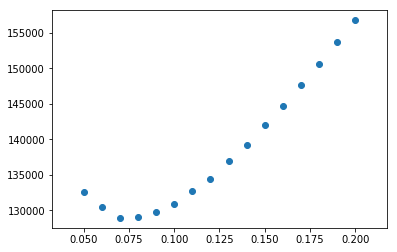

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline 

def kernel_epa(u):
    w = (abs(u) <= 1) * (1 - u*u)
    return w[w > 0]

h = np.arange(.05, .2, .01)
risk = [0] * len(h)

def leave_one_out(h, flux): 
    validerror = 0 
    for j in range(0,len(flux)): 
        for i in range (0, (len(flux[j]))): 
            if (i == 2378):
                break
            y = list(flux[j][:i]) + list(flux[j][i+1:])
            ux = np.append( u[:i], u[i+1:])
            w = kernel_epa(ux/h)
            const = np.convolve(w, np.ones(len(ux), dtype=np.float64), 'same')
            yhat = np.convolve(w, y, 'same') / const 
            yhati = (yhat[i] + yhat[i+1]) / 2 
            diff = (flux[j][i] - yhati)**2
            validerror = validerror + diff
            verror = validerror / N 
    print verror 
    return verror

for i in range(0, len(h)):
    risk[i] = leave_one_out(h[i] , fluxs)

print risk
best_h = h[np.argmin(np.array(risk))]
plt.scatter(h, risk) 

In [66]:


def yhat_residual(w,const,beta,flux):
    # compute the residual
    yhat = np.convolve(w, np.nan_to_num(flux), 'same') / const
    res = np.nan_to_num(flux) - yhat
    
    # standardize the residual
    avg = np.mean(res)
    sigma = 1.4826*np.median(np.abs(res - np.median(res)))
    res = [(r - avg)/sigma for r in res]
    
    # threshold the residual
    neg_beta = -beta 
    res = [r if r < neg_beta else 0 for r in res]
    
    return (yhat,res)

w = kernel_epa(u/best_h)
const = np.convolve(w, np.ones(len(u), dtype=np.float64), 'same')
beta = np.sqrt(2*np.log(N))
names = lc.rdd.map(lambda x: x['name']).collect()
time_yhat_thresres = [0, 0] * 12 
for i in range(len(fluxs)): 
    time_yhat_thresres[i] = yhat_residual(w, const, beta, fluxs[i])
    


#time_yhat_thresres = lc.rdd.map(lambda x: (x['time'],yhat_residual(w,const,beta,x['flux']))).collect() # time, yhat, residual with threshold

Star: kplr002581316-2012277125453_llc
Label: conf


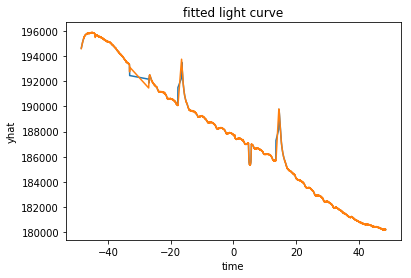

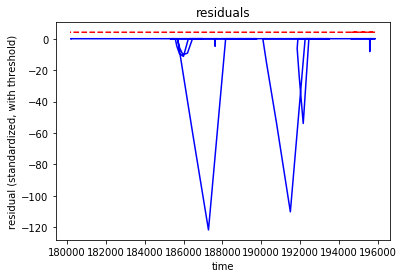

Star: kplr003632418-2012277125453_llc
Label: conf


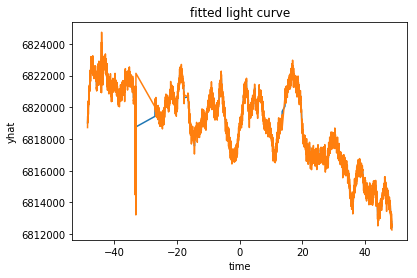

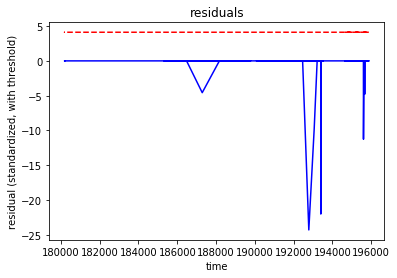

Star: kplr003733628-2012277125453_llc
Label: conf


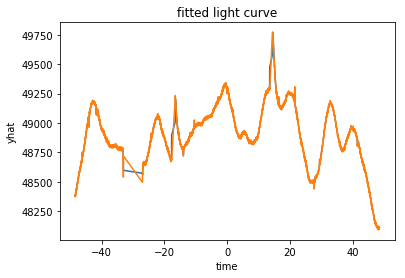

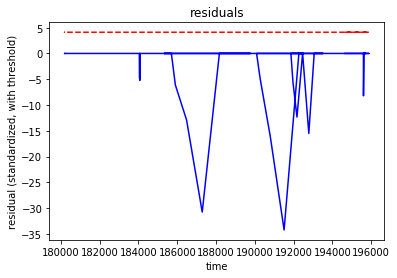

Star: kplr004150804-2012277125453_llc
Label: conf


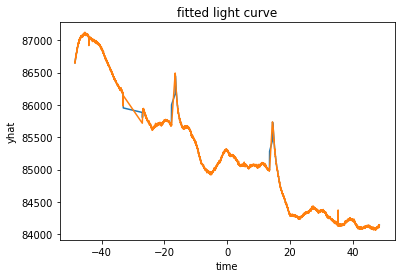

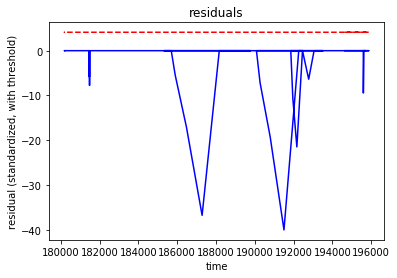

Star: kplr001026032-2012277125453_llc
Label: eb


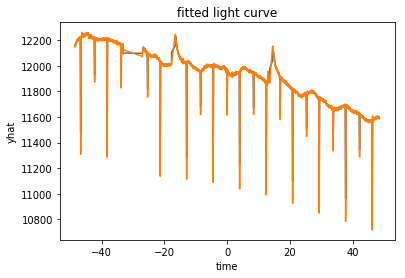

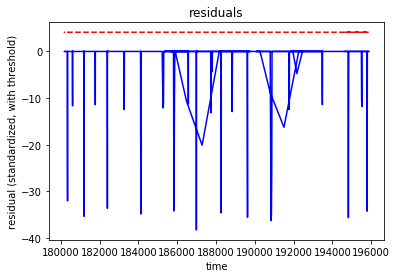

Star: kplr001026957-2012277125453_llc
Label: eb


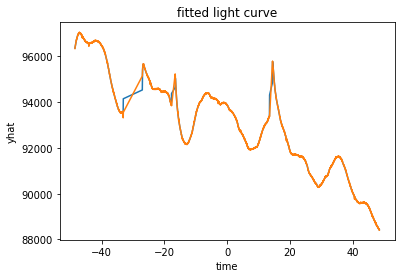

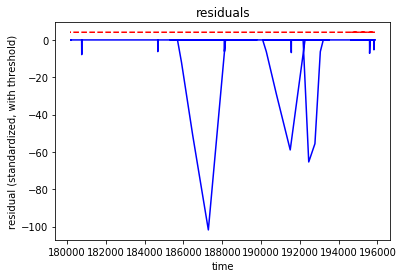

Star: kplr001161345-2012277125453_llc
Label: eb


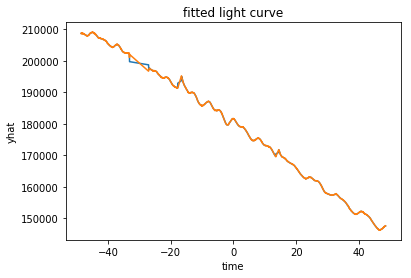

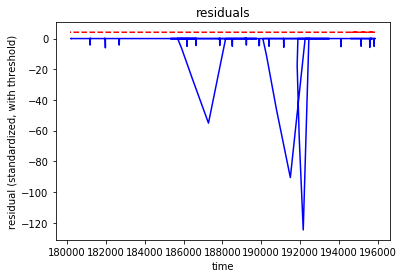

Star: kplr001432214-2012277125453_llc
Label: eb


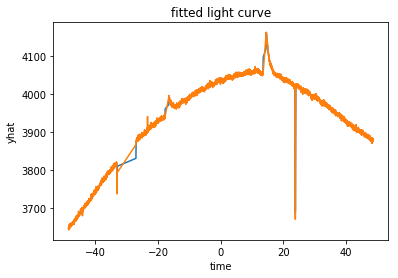

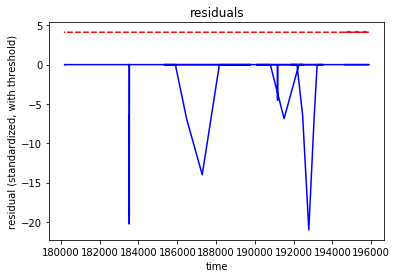

Star: kplr000892772-2012277125453_llc
Label: fp


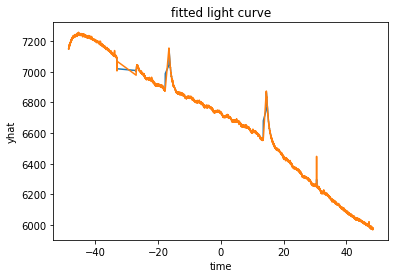

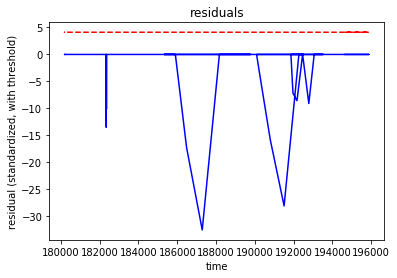

Star: kplr001025986-2012277125453_llc
Label: fp


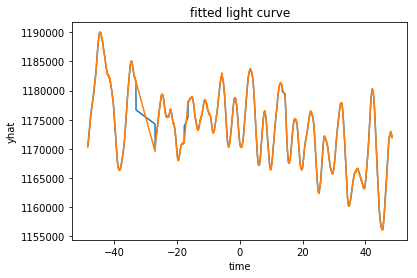

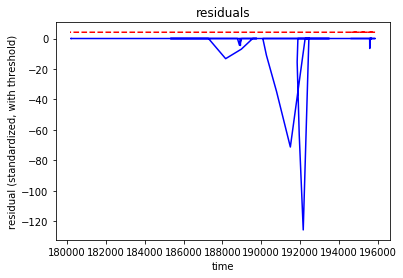

Star: kplr001027438-2012277125453_llc
Label: fp


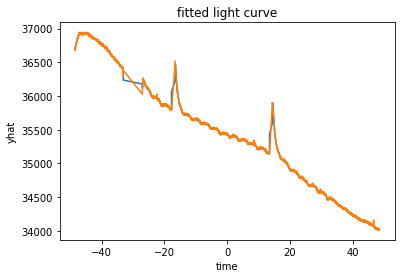

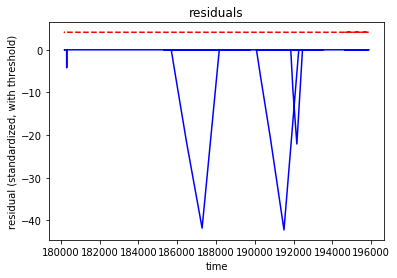

Star: kplr001161949-2012277125453_llc
Label: fp


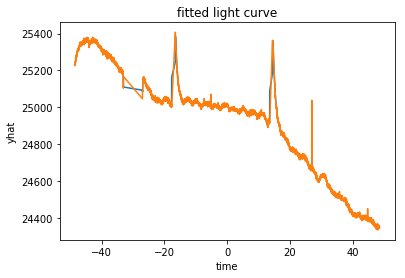

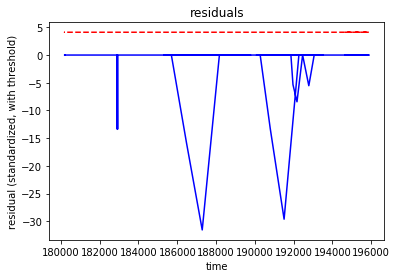

In [85]:
labels = lc.rdd.map(lambda x: x['label']).collect()

for i in range(0,12):
    
    print "Star: " + names[i]
    print "Label: " + labels[i]
    yhat = time_yhat_thresres[i][0]
    thres_res = time_yhat_thresres[i][1]
    
    # plot fitted light curve
    plt.figure()
    plt.plot(u,yhat)
    plt.plot(u, fluxs[i])
    plt.xlabel('time')
    plt.ylabel('yhat')
    plt.title('fitted light curve')
    plt.show()
    
    
    betar = np.full(4325, beta)
    # plot residuals with threshold shown
    plt.figure()
    plt.plot(time, thres_res, 'b', time, betar, 'r--',)
    plt.xlabel('time')
    plt.ylabel('residual (standardized, with threshold)')
    plt.title('residuals')
    plt.show()

TODO - Comment on the results, and whether or not the fits suggest a planet or binary star system. Describe your procedures and findings in the notebook, including various plots of your regression fits.

Wow, so it took a while to get this actually looking like something that is meanigful. In the write up it just suggests treating all the Nan values as zeros. This actually messes up the regression a lot. I was doing a lot of fiddling around with the bandwidth to try and see what worked but havung all those values in actually really messed up the data. The fit was awful for all the different badwidth and the regression plots were really bad. Once I got rid of the Nan values in both the time vector and the xs the regression became a lot better of a fit and now the residaul plot actually shows something meanigful. I am kind of suprised by the bandwidth that i got as a result from the leave one out cross validation. I get a bandwidth of .07 which seems to be very small but look at the yhats plotted next to the actuall values it seems to be a relatively good fit. Now we can discuss what we think of each type of planet/star. Almost all of the stars in the residual plots have two large dips. The eb stars are a bit more all over the place in the residaul plots with a bunch of different dips. A lot of them very small and for a very short period of time. It is actually kind of hard to seperate out the different types of planets from just looking at the plots. 